# Cascading Bandits for Ranked Recommendations
## Graded Assignment

This assignment explores cascading bandits: how to learn optimal rankings when users examine items sequentially and stop at the first click.

The assignment has two parts:
1. **Part A: Non-contextual bandits (synthetic data)**
2. **Part B: Contextual bandits with movie recommendations (MovieLens)** 


## References

Kveton, B., Szepesvari, C., Wen, Z., & Ashkan, A. (2015, June). Cascading bandits: Learning to rank in the cascade model. In *International conference on machine learning* (pp. 767-776). PMLR.

## Setup: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import urllib.request
import zipfile
import os

---

# Part A: Non-Contextual Cascading Bandits

## Learning Rankings with Fixed Item Attractiveness

**Context:**
- You have L items (e.g., movies, products, articles)
- Each item has an unknown "attraction probability" $w_i$ (how likely users click)
- At each round, you select and display K items in a ranked list
- Users examine items from position 1 to K
- When a user encounters an attractive item, they click and stop (we call this a cascade)
- You only observe feedback up to the first click—items below are invisible

**Goal:** Learn to rank items optimally to maximize total clicks over T rounds.

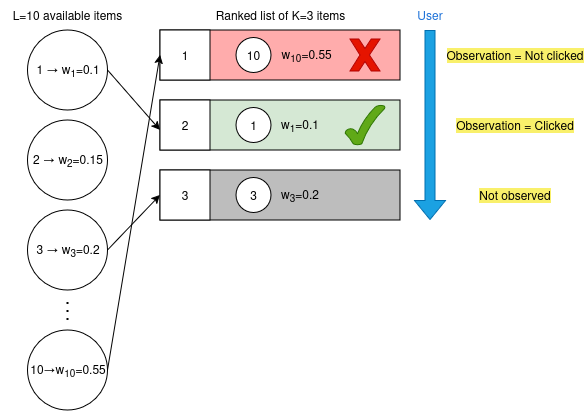

**Question**: If you had access to the attraction probabilities, what do you think the optimal policy for selecting and ranking items would be in this setting? Explain your reasoning.

### Cascading Bandit Environment

In [ ]:
class CascadingBandit:
    """
    Non-contextual cascading bandit environment.

    Each item has a fixed (but unknown) attraction probability.
    When you display a list, users examine items sequentially and click the first
    attractive item they find, then stop.
    """

    def __init__(self, attraction_probs: List[float]):
        """
        Args:
            attraction_probs: List of attraction probabilities, one per item
        """
        self.L = len(attraction_probs)
        self.attraction_probs = np.array(attraction_probs)
        self.K_opt = None
        self.optimal_value = None

    def display_list(self, item_list: List[int]) -> Tuple[int, List[int]]:
        """
        Display a ranked list and observe cascade feedback.

        Args:
            item_list: Ordered list of item indices to display

        Returns:
            clicked_position: Which position was clicked (-1 if no click)
            examined_items: Which items the user examined
        """
        examined_items = []
        for position, item_idx in enumerate(item_list):
            examined_items.append(item_idx)
            if np.random.random() < self.attraction_probs[item_idx]:
                return position, examined_items
        return -1, examined_items

    def optimal_ranking(self, K: int) -> List[int]:
        """Return top-K items ranked by attraction probability."""
        self.K_opt = K
        top_items = np.argsort(self.attraction_probs)[::-1][:K]
        self.optimal_value = 1.0 - np.prod(1.0 - self.attraction_probs[top_items])
        return top_items.tolist()

    def get_reward(self, item_list: List[int]) -> float:
        """
        Compute expected reward for a given ranking (probability of getting a click).

        Args:
            item_list: Ordered list of item indices

        Returns:
            Expected probability of click for this ranking
        """
        prob_no_click = 1.0
        for item_idx in item_list:
            prob_no_click *= (1.0 - self.attraction_probs[item_idx])
        return 1.0 - prob_no_click

### Baseline Algorithm

As a baseline, we implement RandomRanking: at each round, select K random items and display them in random order.

In [ ]:
class RandomRanking:
    """
    Baseline: select and rank K items randomly.
    No learning occurs.
    """

    def __init__(self, bandit: CascadingBandit, K: int):
        self.bandit = bandit
        self.K = K
        self.L = bandit.L

        self.cumulative_regret = []
        self.total_regret = 0

    def select_items(self, t: int) -> List[int]:
        """Select K random items."""
        return np.random.choice(self.L, size=self.K, replace=False).tolist()

    def run(self, T: int):
        """Run the baseline for T rounds."""
        for t in range(1, T + 1):
            items = self.select_items(t)
            clicked_pos, examined_items = self.bandit.display_list(items)

            got_click = clicked_pos >= 0
            instant_reward = 1.0 if got_click else 0.0

            # Regret: optimal reward - realized reward
            optimal_reward = self.bandit.optimal_value
            instant_regret = optimal_reward - instant_reward
            self.total_regret += instant_regret
            self.cumulative_regret.append(self.total_regret)

### TASK A.1: Implement CascadeUCB Algorithm

CascadeUCB (Kveton et al. 2015) uses the Upper Confidence Bound (UCB) strategy to balance exploration and exploitation.

**Note:**
- Only update counts for items the user actually examined, since you have no feedback on the items ranked after the first item clicked

In [ ]:
class CascadeUCB:
    """
    UCB algorithm for cascading bandits.

    Balances exploration (items we haven't seen much) with exploitation
    (items that seem attractive based on observed clicks).
    """

    def __init__(self, bandit: CascadingBandit, K: int):
        """
        Args:
            bandit: The cascading bandit environment
            K: Number of items to display per round
        """
        self.bandit = bandit
        self.K = K
        self.L = bandit.L

        # Counters for each item
        self.N = np.zeros(self.L)  # Times examined
        self.C = np.zeros(self.L)  # Times clicked

        # Statistics
        self.cumulative_regret = []
        self.total_regret = 0

    def select_items(self, t: int) -> List[int]:
        """
        Select K items using UCB strategy.

        Returns an ordered list of K item indices, ranked by UCB value.
        """
        ucb_values = np.zeros(self.L)

        # TODO: Task A.1 - Compute UCB values for each item
        raise NotImplementedError("Task A.1")

        # TODO: Task A.1 - Select top-K items by UCB value and rank them
        raise NotImplementedError("Task A.1")

    def update(self, item_list: List[int], clicked_pos: int, examined_items: List[int]):
        """
        Update algorithm based on observed feedback.

        Args:
            item_list: The list that was displayed
            clicked_pos: Position clicked (-1 if no click)
            examined_items: Items the user examined (cascade rule!)
        """
        # TODO: Task A.1 - Update examination counts for examined items
        raise NotImplementedError("Task A.1")

        # TODO: Task A.1 - Update click count if there was a click
        raise NotImplementedError("Task A.1")

    def run(self, T: int):
        """Run the algorithm for T rounds."""
        for t in range(1, T + 1):
            items = self.select_items(t)
            clicked_pos, examined_items = self.bandit.display_list(items)

            got_click = clicked_pos >= 0
            instant_reward = 1.0 if got_click else 0.0

            # Regret: optimal reward - realized reward
            optimal_reward = self.bandit.optimal_value
            instant_regret = optimal_reward - instant_reward
            self.total_regret += instant_regret
            self.cumulative_regret.append(self.total_regret)

            self.update(items, clicked_pos, examined_items)

### TASK A.2: Experiment on Synthetic Data

**Experimental setup:**
- L = 10 items with attraction probabilities [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
- K = 3 items per list
- T = 1000 rounds
- Run 100 repetitions to get error bars

In [ ]:
def run_experiment_part_a():
    """Experiment on synthetic cascading bandits data."""

    print("=" * 70)
    print("PART A: Non-Contextual Cascading Bandits")
    print("=" * 70)

    np.random.seed(42)

    # Setup
    attraction_probs = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
    bandit = CascadingBandit(attraction_probs)

    K = 3
    T = 1000
    repetitions = 100

    print(f"\nSetup:")
    print(f"  Items: {bandit.L} items")
    print(f"  Attraction probs: {attraction_probs}")
    print(f"  List size K: {K}")
    print(f"  Rounds T: {T}")
    print(f"  Repetitions: {repetitions}")
    print(f"  Optimal ranking: {bandit.optimal_ranking(K)}")

    # TODO: Task A.2 - Run experiments with CascadeUCB and RandomRanking
    raise NotImplementedError("Task A.2")

    # TODO: Task A.2 - Plot cumulative regret with error bars
    raise NotImplementedError("Task A.2")

    # TODO: Task A.2 - Display final performance statistics
    raise NotImplementedError("Task A.2")

In [ ]:
# Run Part A experiments
run_experiment_part_a()

**Question**: What do you observe about the performance of CascadeUCB compared to RandomRanking? Can you get better performance? (Think hyperparameters, alternative indices, Thompson Sampling, etc.)

---

# Part B: Contextual Cascading Bandits - Open Project

## Personalized Movie Recommendations with MovieLens

### Problem Statement

In this part, you will apply cascading bandits to a movie recommendation problem using the MovieLens 100K dataset. Unlike Part A where item attractiveness was fixed, here you must learn **personalized** rankings that depend on user context.

**The Challenge:**
- Users have different preferences (age, gender, occupation affect movie taste)
- Movies have different characteristics (genres: Action, Comedy, Drama, ...)
- You must learn which movies to recommend to which users
- Users follow the cascade model: they examine movies sequentially and click the first one they like
- Your **goal** is to maximize total clicks over T rounds

### Dataset

MovieLens 100K contains:
- 943 users with demographic features
- 1,682 movies with genre labels  
- 100,000 ratings (1-5 stars)

The data loading code is provided below.

### Your Task

1. **Formulate the problem** as a contextual cascading bandit:
   - What is the context? 
   - How do you convert ratings to click probabilities? You are free to model this as you see fit as long as you justify your choices.

2. **Design and implement** a contextual cascading bandit algorithm:
   - Consider adapting contextual bandit algorithms (e.g. LinUCB) to the cascading setting
   - Think about how to model user-movie interactions

3. **Evaluate your approach:**
   - Compare against a reasonable baseline
   - Plot learning curves (cumulative regret over time)
   - Analyze the results: does personalization help?

4. **Experiment with variations:**
   - Try different feature representations
   - Test different exploration parameters and strategies

### Submission

Submit a **3-page report** (PDF) of your experiments and algorithm design choices. Your report should include justifications for your choices, references to relevant literature, and plots illustrating your results.

When you are done, please send your report as a PDF to [thomas.michel@inria.fr](mailto:thomas.michel@inria.fr)

The deadline for submission is **November 21st, 2025**.

### Hints

- Start simple: get a basic contextual algorithm working first
- Feature engineering matters: how you combine user/movie features affects performance
- Use a subset of movies (30-50) to speed up experimentation

### Data Loading and Preprocessing

The following code loads and preprocesses the MovieLens dataset for you.

In [ ]:
class MovieLensLoader:
    """
    Load and preprocess MovieLens 100K dataset.

    Dataset: https://grouplens.org/datasets/movielens/100k/
    Contains 100,000 ratings from 943 users on 1,682 movies.
    """

    def __init__(self, data_dir: str = "./ml-100k"):
        self.data_dir = data_dir
        self.movies = None
        self.users = None
        self.ratings = None

    def download_data(self):
        """Download MovieLens 100K if not already present."""
        if not os.path.exists(self.data_dir):
            print("Downloading MovieLens 100K dataset...")
            url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
            zip_path = "ml-100k.zip"

            urllib.request.urlretrieve(url, zip_path)
            with zipfile.ZipFile(zip_path, "r") as zip_ref:
                zip_ref.extractall(".")
            os.remove(zip_path)
            print("Download complete!")
        else:
            print("Dataset already exists.")

    def load_data(self):
        """Load movies, users, and ratings from files."""
        self.download_data()

        # Movie columns (includes 19 binary genre indicators)
        movie_cols = [
            "movie_id", "title", "release_date", "video_release_date", "imdb_url",
            "unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
            "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
            "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western",
        ]

        self.movies = pd.read_csv(
            os.path.join(self.data_dir, "u.item"),
            sep="|",
            names=movie_cols,
            encoding="latin-1",
        )

        # User columns
        user_cols = ["user_id", "age", "gender", "occupation", "zip_code"]
        self.users = pd.read_csv(
            os.path.join(self.data_dir, "u.user"),
            sep="|",
            names=user_cols,
            encoding="latin-1",
        )

        # Rating columns
        rating_cols = ["user_id", "movie_id", "rating", "timestamp"]
        self.ratings = pd.read_csv(
            os.path.join(self.data_dir, "u.data"),
            sep="\t",
            names=rating_cols,
        )

        print(f"Loaded {len(self.movies)} movies, {len(self.users)} users, {len(self.ratings)} ratings")
        return self

    def prepare_features(self, num_movies: int = 50):
        """
        Extract and prepare feature matrices.

        Args:
            num_movies: Number of top-rated movies to use

        Returns:
            user_features: (n_users, d_user) array
            movie_features: (n_movies, d_movie) array [genres]
            ratings_matrix: (n_users, n_movies) [NaN for unobserved]
            user_ids: user IDs
            movie_ids: movie IDs
        """
        # Select top-rated movies
        movie_popularity = self.ratings.groupby("movie_id").size().sort_values(ascending=False)
        top_movies = movie_popularity.head(num_movies).index.tolist()

        movies_subset = self.movies[self.movies["movie_id"].isin(top_movies)].copy()
        ratings_subset = self.ratings[self.ratings["movie_id"].isin(top_movies)].copy()

        # Movie features: genre binary indicators (19 genres)
        genre_cols = [
            "unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
            "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
            "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western",
        ]

        movie_features = movies_subset[genre_cols].values.astype(float)
        movie_ids = movies_subset["movie_id"].values

        # User features: age (normalized), gender (binary), occupation (one-hot)
        users_subset = self.users.copy()

        users_subset["age_normalized"] = (
            (users_subset["age"] - users_subset["age"].mean()) / users_subset["age"].std()
        )
        users_subset["gender_encoded"] = (users_subset["gender"] == "M").astype(float)

        occupation_dummies = pd.get_dummies(users_subset["occupation"], prefix="occ")

        user_feature_df = pd.concat(
            [
                users_subset[["user_id", "age_normalized", "gender_encoded"]],
                occupation_dummies,
            ],
            axis=1,
        )

        user_features = user_feature_df.drop("user_id", axis=1).values
        user_ids = user_feature_df["user_id"].values

        # Create ratings matrix (NaN for unobserved)
        ratings_matrix = np.full((len(user_ids), len(movie_ids)), np.nan)

        for _, row in ratings_subset.iterrows():
            user_idx = np.where(user_ids == row["user_id"])[0]
            movie_idx = np.where(movie_ids == row["movie_id"])[0]
            if len(user_idx) > 0 and len(movie_idx) > 0:
                ratings_matrix[user_idx[0], movie_idx[0]] = row["rating"]

        # Normalize movie features
        movie_features = movie_features / (np.linalg.norm(movie_features, axis=1, keepdims=True) + 1e-8)

        print(f"\nFeature dimensions:")
        print(f"  User features: {user_features.shape}")
        print(f"  Movie features: {movie_features.shape}")
        print(f"  Ratings matrix: {ratings_matrix.shape}")
        print(f"  Observed ratings: {np.sum(~np.isnan(ratings_matrix))} / {ratings_matrix.size}")

        return user_features, movie_features, ratings_matrix, user_ids, movie_ids

### Explore the Dataset

Run this cell to load and explore the MovieLens data.

In [ ]:
def explore_dataset():
    """Load and explore the MovieLens dataset."""

    print("=" * 70)
    print("PART B: Contextual Cascading Bandits with MovieLens")
    print("=" * 70)

    print("\n1. Loading dataset...")
    loader = MovieLensLoader()
    loader.load_data()

    print("\n2. Preparing features for top 30 movies...")
    user_features, movie_features, ratings_matrix, user_ids, movie_ids = (
        loader.prepare_features(num_movies=30)
    )

    print("\n3. Sample data:")
    print("\nFirst 5 users (demographic features):")
    sample_users = pd.DataFrame(
        user_features[:5],
        columns=[f"feature_{i}" for i in range(user_features.shape[1])]
    )
    print(sample_users)

    print("\nFirst 5 movies (genre features):")
    genre_cols = ["unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
                  "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
                  "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
    sample_movies = pd.DataFrame(
        movie_features[:5],
        columns=genre_cols
    )
    print(sample_movies)

    print("\nRatings distribution (first 5 users, first 10 movies):")
    sample_ratings = ratings_matrix[:5, :10]
    ratings_df = pd.DataFrame(sample_ratings, columns=[f"movie_{i}" for i in range(10)])
    print(ratings_df)

    print("\nRatings statistics:")
    all_ratings = ratings_matrix[~np.isnan(ratings_matrix)]
    print(f"  Mean rating: {np.mean(all_ratings):.2f}")
    print(f"  Std: {np.std(all_ratings):.2f}")
    print(f"  Min: {np.min(all_ratings):.0f}, Max: {np.max(all_ratings):.0f}")

    return user_features, movie_features, ratings_matrix, user_ids, movie_ids

# Explore the dataset
user_features, movie_features, ratings_matrix, user_ids, movie_ids = explore_dataset()